In [1]:
# import packages
import numpy as np
import pickle as pk
import pandas as pd
import seaborn as sns
from matplotlib import pyplot 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
# package that will help us to save tough models, this will allow us to run all notebook quickly 
import pickle
from math import sqrt
import matplotlib.pyplot as plt
import json
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity



In [2]:
# load data 
movies = pd.read_csv("../datasets/ml-25m/movies.csv")
ratings = pd.read_csv("../datasets/ml-25m/ratings.csv")

In [3]:
# dummy encode genre 
genres_encoded = movies['genres'].str.get_dummies('|')

# merge with original
df_encoded = pd.concat([movies, genres_encoded], axis=1)

# drop genre and no genre listed columns
df_encoded.drop(columns=["genres","(no genres listed)"], inplace=True)

In [4]:
# add column for year
df_encoded['year'] = df_encoded['title'].str.extract(r'\((\d{4})\)')
df_encoded['year'] = df_encoded['year'].fillna(0).astype('int64')
df_encoded.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1995
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995


In [5]:
# merge rating and encoded dataframes 
merged = ratings.merge(df_encoded,on="movieId")
merged.head()

,userId,movieId,rating,timestamp,title,Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,296,5.0,1147880044,Pulp Fiction (1994),0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1994
1,3,296,5.0,1439474476,Pulp Fiction (1994),0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1994
2,4,296,4.0,1573938898,Pulp Fiction (1994),0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1994
3,5,296,4.0,830786155,Pulp Fiction (1994),0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1994
4,7,296,4.0,835444730,Pulp Fiction (1994),0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1994


In [6]:
# drop timestamp column 
merged.drop(columns="timestamp",inplace = True)

In [7]:
# display NA values  
merged.isna().sum()

userId         0
movieId        0
rating         0
title          0
Action         0
Adventure      0
Animation      0
Children       0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
IMAX           0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
year           0
dtype: int64

In [8]:
# take sample of 100k records from merged dataset
merged_sample = merged.sample(100000)

In [9]:
# rating is a float number, to pass it to model, we need integer value
encoder = {
          0.5: 1,
          1 : 2,
          1.5: 3,
          2:4,
          2.5 : 5,
          3:6,
          3.5:7,
          4:8,
          4.5:9,
          5:10
           }
merged_sample["rating"] = merged_sample["rating"].map(encoder)

In [10]:
# select predictor columns
columns_X = merged_sample.columns.to_list()
columns_X.remove("rating")
columns_X.remove("title")
columns_X  

['userId',
 'movieId',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'year']

In [11]:
# declare X and y values 
X = merged_sample[columns_X]
y = merged_sample["rating"]

In [12]:
# select few algorithms for comparison 
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('DT', DecisionTreeRegressor()))
models.append(("RF", RandomForestClassifier()))
models.append(('NB', GaussianNB()))

In [13]:
# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y , 
                                   random_state=104,  
                                   test_size=0.3,  
                                   shuffle=True) 


In [14]:
# scale training ans testing set 
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)  

In [15]:
# perform stratified k fold cross validation to see, which model performs the best 
results = []
names = []
for name, model in models:
  kfold = StratifiedKFold(n_splits=5, random_state=104, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  print('%s: %f (%f)' % (name, (cv_results.mean() * -1), cv_results.std())) 

LDA: 2.270327 (0.008395)
DT: 2.781511 (0.015525)


KeyboardInterrupt: 

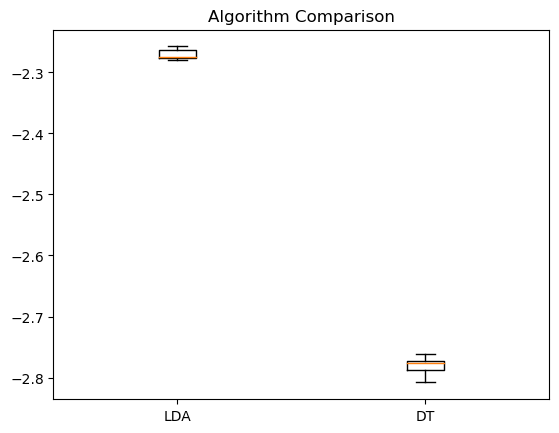

In [16]:
# plot boxplot of results for each algorithm 
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show() 

In [17]:
# free up memory 
models = None

In [ ]:
# we can see that LDA performed the best, we can now try to optimise it with grid search
parameters = {
    'n_components': [None, 1, 2, 3],
    'tol': [1e-4, 1e-3, 1e-2],
    'store_covariance': [True, False],
}

# Initialize LDA
lda = LinearDiscriminantAnalysis()

# Perform grid search
grid_search = GridSearchCV(lda, parameters, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

At this point, we have chosen and optimised one of models available in sklearn package.  
In the next part, we will compare it to algorithm obtained from Suprise package, which was influenced by SVD algorithm. 

In [18]:
# SVD algorithm
class SVD():

    def __init__(self, n_factors=100, n_epochs=20, biased=True, init_mean=0,
                 init_std_dev=.1, lr_all=.005,
                 reg_all=.02, lr_bu=None, lr_bi=None, lr_pu=None, lr_qi=None,
                 reg_bu=None, reg_bi=None, reg_pu=None, reg_qi=None,
                 random_state=None, verbose=False):

        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.biased = biased
        self.init_mean = init_mean
        self.init_std_dev = init_std_dev
        self.lr_bu = lr_bu if lr_bu is not None else lr_all
        self.lr_bi = lr_bi if lr_bi is not None else lr_all
        self.lr_pu = lr_pu if lr_pu is not None else lr_all
        self.lr_qi = lr_qi if lr_qi is not None else lr_all
        self.reg_bu = reg_bu if reg_bu is not None else reg_all
        self.reg_bi = reg_bi if reg_bi is not None else reg_all
        self.reg_pu = reg_pu if reg_pu is not None else reg_all
        self.reg_qi = reg_qi if reg_qi is not None else reg_all
        self.random_state = random_state
        self.verbose = verbose


    def fit(self, X, y):
      
        data = X.join(y)
        self.n_users = data["userId"].unique().max() + 1
        self.n_items = data["movieId"].unique().max() + 1
        self.global_mean = y.mean()
        self.dataset = data
        self.train_data = data.to_numpy()

        self.sgd(data)

        return self

    def sgd(self, data):
      
        rng =  np.random.RandomState()

        # user biases
        bu = np.zeros(self.n_users, dtype=np.double)
        # item biases
        bi = np.zeros(self.n_items, dtype=np.double)
        # user factors
        pu = rng.normal(self.init_mean, self.init_std_dev, size=(self.n_users, self.n_factors))
        # item factors
        qi = rng.normal(self.init_mean, self.init_std_dev, size=(self.n_items, self.n_factors))

        # u, i, f
        n_factors = self.n_factors
        biased = self.biased

        # r, err, dot, puf, qif
        global_mean = self.global_mean

        lr_bu = self.lr_bu
        lr_bi = self.lr_bi
        lr_pu = self.lr_pu
        lr_qi = self.lr_qi

        reg_bu = self.reg_bu
        reg_bi = self.reg_bi
        reg_pu = self.reg_pu
        reg_qi = self.reg_qi

        if not biased:
            global_mean = 0

        for current_epoch in range(self.n_epochs):
            if self.verbose:
                print("Processing epoch {}".format(current_epoch))

            for  u, i, r in self.train_data:
                # compute current error
                u = int(u)
                i = int(i)
                r = int(r)
                dot = 0  # <q_i, p_u>
                for f in range(n_factors):
                    dot += qi[i, f] * pu[u, f]
                err = r - (global_mean + bu[u] + bi[i] + dot)

                # update biases
                if biased:
                    bu[u] += lr_bu * (err - reg_bu * bu[u])
                    bi[i] += lr_bi * (err - reg_bi * bi[i])

                # update factors
                for f in range(n_factors):
                    puf = pu[u, f]
                    qif = qi[i, f]
                    pu[u, f] += lr_pu * (err * qif - reg_pu * puf)
                    qi[i, f] += lr_qi * (err * puf - reg_qi * qif)

        self.bu = np.asarray(bu)
        self.bi = np.asarray(bi)
        self.pu = np.asarray(pu)
        self.qi = np.asarray(qi)
    
    def predict(self,X):
      
        y= []
        X = X.to_numpy()
        for u, i in X:
            y.append(self.estimate(u,i))
        return y

        

    def estimate(self, u, i):

        # known_user = u in self.dataset["userId"].values
        # known_item = i in self.dataset["movieId"].values
        known_user = False
        known_item = False
        try: 
            known_user = self.bu[u] != None
        except: 
            pass
        try:
            known_item = self.bi[i] != None
        except:
            pass
        
        if self.biased:
            est = self.global_mean

            if known_user:
                est += self.bu[u]

            if known_item:
                est += self.bi[i]

            if known_user and known_item:
                est += np.dot(self.qi[i], self.pu[u])

        else:
            if known_user and known_item:
                est = np.dot(self.qi[i], self.pu[u])
            else:
                raise KeyError('User and item are unknown.')

        return est

testing and validation 

In [19]:
# defining number of users for test comparison between custom svd and from sklearn
sample_size = [10000, 15000, 30000, 45000, 60000]

In [20]:
# results
algo_sklearn_rmse = []
algo_svd_rmse = []

In [21]:
# try and see if sklearn-algo test results are available 
try: 
  with open('../results/algo_sklearn_rmse.txt', 'r') as file:
    results = file.readline()
    algo_sklearn_rmse = json.loads(results)
except:
  pass

algo_sklearn_rmse

[2.3425769286549945,
 2.35055548990257,
 2.2933478681709945,
 2.2902369277402688,
 2.2633308787419186]

In [22]:
# try and see if svd-algo test results are available 
try: 
  with open('../results/algo_svd_rmse.txt', 'r') as file:
    results = file.readline()
    algo_svd_rmse = json.loads(results)
except:
  pass

algo_svd_rmse

[2.0972767214259664,
 2.0317441172867183,
 2.024771974793931,
 2.0179876383358613,
 1.9939544299828276]

In [23]:

for size in sample_size:
    sample_data = merged_sample[:size]
    X = sample_data[columns_X]
    y = sample_data["rating"]
    X_train, X_test, y_train, y_test = train_test_split(X,y , 
                                   random_state=104,  
                                   test_size=0.3,  
                                   shuffle=True) 


    model_sklearn = LinearDiscriminantAnalysis(**grid_search.best_params_)
    m1_pred = model_sklearn.fit(X_train,y_train).predict(X_test)
    mse_1 = mean_squared_error(y_test, m1_pred)
    algo_sklearn_rmse.append(sqrt(mse_1))

    X_test = X_test[["userId","movieId"]]
    X_train = X_train[["userId","movieId"]]
    model_svd = SVD()
    m2_pred = model_svd.fit(X_train,y_train).predict(X_test)
    mse_2 = mean_squared_error(y_test, m2_pred)
    algo_svd_rmse.append(sqrt(mse_2))


NameError: name 'grid_search' is not defined

Save both results

In [24]:
with open('../results/algo_svd_rmse.txt', 'w') as file:
    json.dump(algo_svd_rmse, file)
with open('../results/algo_sklearn_rmse.txt', 'w') as file:
    json.dump(algo_sklearn_rmse, file)

In [25]:
print(algo_sklearn_rmse)
print(algo_svd_rmse)

[2.3425769286549945, 2.35055548990257, 2.2933478681709945, 2.2902369277402688, 2.2633308787419186]
[2.0972767214259664, 2.0317441172867183, 2.024771974793931, 2.0179876383358613, 1.9939544299828276]


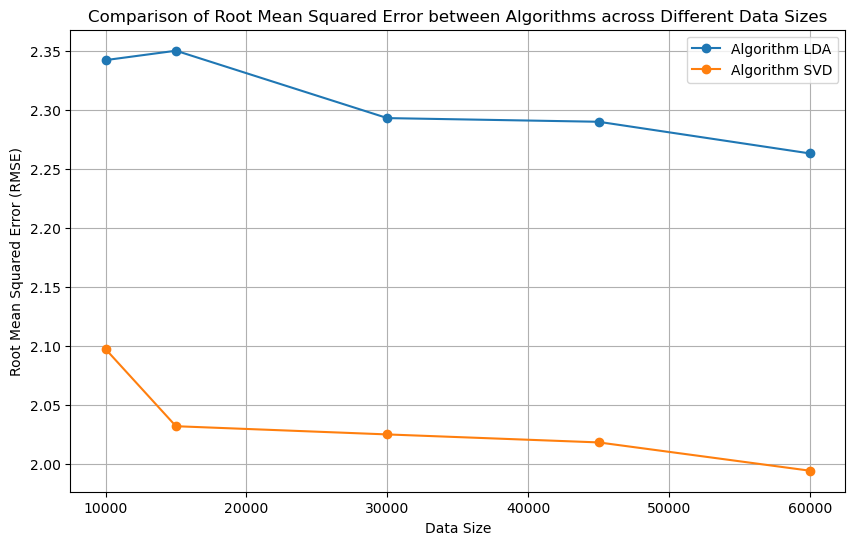

In [26]:
plt.figure(figsize=(10, 6))

plt.plot(sample_size, algo_sklearn_rmse, marker='o', label='Algorithm LDA')
plt.plot(sample_size, algo_svd_rmse, marker='o', label='Algorithm SVD')

plt.xlabel('Data Size')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Comparison of Root Mean Squared Error between Algorithms across Different Data Sizes')
plt.legend()
plt.grid(True)

plt.show()

Further testing custom SVD algorithm 

In [ ]:
svd_test_sample_sizes = [100000, 150000, 200000, 250000, 300000]

In [ ]:
svd_test_results = []

In [27]:
# check if svd test results are available 
try: 
  with open('../results/svd_test_results.txt', 'r') as file:
    results = file.readline()
    svd_test_results = json.loads(results)
except:
  pass

svd_test_results

[0.9006278666703769,
 0.8875418291392679,
 0.8897943777437072,
 0.8929683790519847,
 0.8827326542021469]

In [ ]:
#run tests only if results are not available 
if len(svd_test_results) == 0:
  for n in svd_test_sample_sizes:
    sample = ratings[:n]
    X = sample[["userId","movieId"]]
    y = sample["rating"]
    X_train, X_test, y_train, y_test = train_test_split(X,y , 
                                    random_state=104,  
                                    test_size=0.3,  
                                    shuffle=True) 
    
    # try to load pre-trained model, random state will assure that model  is trained and tested on the same data 
    filename = '../models/model_test_' + str(n) + '.sav'
    model = None
    try:
      model = pickle.load(open(filename, 'rb'))
    except:
      print("Pretrained model not found: " + 'model_test_' + str(n))
      pass
    # only train model if not available
    if model == None:
      model = SVD()
      model = model.fit(X_train,y_train)
      
    y_pred_svd = model.predict(X_test)
    mse_svd = mean_squared_error(y_test, y_pred_svd)
    svd_test_results.append(sqrt(mse_svd))
    # save model 
    pickle.dump(model, open(filename, 'wb'))
  


In [ ]:
# save results from svd test  
with open('../results/svd_test_results.txt', 'w') as filehandle:
    json.dump(svd_test_results, filehandle)

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(svd_test_sample_sizes, svd_test_results, marker='o', label='SVD Custom Algorithm')

plt.xlabel('Sample Size')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Performance of SVD algorithm with increasing data sample size')
plt.legend()
plt.grid(True)

plt.show()

### Training final model

With this algorithm, the more data about movie and user we can provide, ie rating score, the better it performs. 

Its because, it adjusts biases from user and movie. 

Let us filter dataframe for movies that were rated more than 10000 times. This will help with time required to train the model and will assure that model has enough data to perform well.

In [3]:
#filter for movies that were rated more than 10k times 
movie_ratings_count = ratings['movieId'].value_counts().reset_index()
ids_10k = movie_ratings_count[movie_ratings_count["count"] > 10000]
ids_10k.info()
ids = ids_10k["movieId"].values

<class 'pandas.core.frame.DataFrame'>
Index: 588 entries, 0 to 587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   movieId  588 non-null    int64
 1   count    588 non-null    int64
dtypes: int64(2)
memory usage: 13.8 KB


In [4]:
# filter original dataframe for rows that contain selected movieIds 
ratings_final = ratings[ratings['movieId'].isin(ids)]

After filtering, we have 588 movies in our final dataset

In [5]:
ratings_final["movieId"].nunique()

588

As we can see, after filtering still have 162,000 users in dataset

In [6]:
ratings_final["userId"].nunique()

162109

In [32]:
movies = None
ratings = None

We have reduced size of the dataframe by half 

In [33]:
ratings_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11877943 entries, 0 to 25000093
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 453.1 MB


In [7]:
ratings_final.drop(columns="timestamp", inplace=True)

C:\Users\rober\AppData\Local\Temp\ipykernel_19612\1862968447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_final.drop(columns="timestamp", inplace=True)


In [8]:
filename = "../datasets/ratings_final.csv"
pd.DataFrame(data=ratings_final).to_csv(filename, sep=',', index=False, encoding='utf-8')

In [35]:
X = ratings_final[["userId", "movieId"]]
y = ratings_final["rating"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
X = None
y = None

Load trained model if exists

In [39]:
filename = '../models/final_model.sav'
final_model = None
try:
  final_model = pickle.load(open(filename, 'rb'))
except:
  print("Final model not found")

Training and validating final model

In [40]:
filename = '../models/final_model.sav'
if final_model is None:
  final_model = SVD(n_factors=1, n_epochs=1)
  final_model.fit(X_train, y_train)
# after trained, save final model 
pickle.dump(final_model, open(filename, 'wb'))

In [41]:
y_pred_final = None
y_train_predict_final = None

# Validation 

Test prediction against testing set

In [42]:
# import X_test prediction results if available 
try: 
  with open('../results/final_results_test.txt', 'r') as file:
    results = file.readline()
    y_pred_final = json.loads(results)
except:
  print("Results not found")
  pass

In [43]:
if y_pred_final == None:
  y_pred_final = final_model.predict(X_test)

In [44]:
with open('../results/final_results_test.txt', 'w') as file:
    json.dump(y_pred_final, file)

Test against training set

In [45]:
# import X_train prediction results if available
try: 
  with open('../results/final_results_train.txt', 'r') as file:
    results = file.readline()
    y_train_predict_final = json.loads(results)
except:
  print("Results not found")
  pass

In [46]:
if y_train_predict_final == None:
  y_train_predict_final = final_model.predict(X_train)

In [47]:
with open('../results/final_results_train.txt', 'w') as file:
    json.dump(y_train_predict_final, file)

In [48]:
mrse_final = sqrt(mean_squared_error(y_test, y_pred_final))
print("Final MRSE for the model is: {n}".format(n = str(mrse_final)))

Final MRSE for the model is: 0.8958018884352629


In [49]:
mrse_final_train = sqrt(mean_squared_error(y_train, y_train_predict_final))
print("Final MRSE for training data the model is: {n}".format(n = str(mrse_final_train)))

Final MRSE for training data the model is: 0.8915284197238758


# Deployment

### Estimated rating dataframe preeprocessing 

In [ ]:
userId = []
movieId = []
rating = []

In [ ]:
unique_user_id = ratings_final["userId"].unique()
unique_movie_id = ratings_final["movieId"].unique()

In [ ]:
for u_id in unique_user_id:
  for m_id in unique_movie_id:
    userId.append(u_id)
    movieId.append(m_id)
    rating.append(final_model.estimate(u_id, m_id))
  

In [50]:
data = {
  "userId": userId,
  "movieId": movieId,
  "rating" : rating
}
filename = "../datasets/final-estimated-rating.csv"
pd.DataFrame(data=data).to_csv(filename, sep=',', index=False, encoding='utf-8')

NameError: name 'userId' is not defined

In [51]:
df_estimated = pd.read_csv("../datasets/final-estimated-rating.csv")

In [52]:
df_estimated["movieId"].nunique()

588

In [53]:
df_estimated["userId"].nunique()

162109

### Cosine similarity 

In [54]:
def find_similar_users(target_user_df, rating_df):
  user_rated = target_user_df["movieId"].values
  ratings = rating_df[rating_df["movieId"].isin(user_rated)]
  similar_users = []
  while len(similar_users) < 5:
    s = ratings.sample(50000)
    df_merged = pd.concat([target_user_df,s])
    # pivot_df = df_merged.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    pivot_df = df_merged.pivot_table(index='userId', columns='movieId', values='rating', aggfunc='mean').fillna(0)
    similarity_matrix = cosine_similarity(pivot_df)
    similarity_matrix_df = pd.DataFrame(similarity_matrix, index=pivot_df.index, columns=pivot_df.index)
    select_user_id = target_user_df["userId"].min()
    # similarities = similarity_matrix_df[select_user_id].drop(select_user_id)
    # weights = similarities/similarities.sum()
    n = 10 
    #set a threshold for similarity
    user_similarity_threshold =  0.8
    similar_users = similarity_matrix_df[similarity_matrix_df[select_user_id]>user_similarity_threshold][select_user_id].sort_values(ascending=False)[:n]
  return similar_users
  

### Create a random user as proof of concept

In [56]:
# select 10 random movie ids to rate
r = np.random.default_rng()
ids = ratings_final["movieId"].values
m_ids = []
ratings = []
for i in range(1,11):
  m_ids.append(ids[r.integers(0,(len(ids) -1 ))])
  ratings.append(r.integers(1,11) / 2)

print(m_ids)
print(ratings)

[3793, 1370, 3753, 92259, 92259, 122882, 1196, 5377, 1291, 91529]
[3.5, 1.5, 2.5, 4.5, 2.0, 1.0, 0.5, 3.5, 1.0, 2.5]


In [57]:
# set target user id to 0 and create user dataframe
user_id = 0
dict = {
  "userId" : [user_id,user_id,user_id,user_id,user_id,user_id,user_id,user_id,user_id,user_id],
  "movieId" : m_ids,
  "rating" : ratings
  # "rating" : [3,4,1,2,4.5,1.5,1.5,3.5,4.5,0.5]
} 
df_user_0 = pd.DataFrame(dict)
df_user_0

,userId,movieId,rating
0,0,3793,3.5
1,0,1370,1.5
2,0,3753,2.5
3,0,92259,4.5
4,0,92259,2.0
5,0,122882,1.0
6,0,1196,0.5
7,0,5377,3.5
8,0,1291,1.0
9,0,91529,2.5


In [60]:
users = find_similar_users(df_user_0, ratings)
print(users)

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
filtered_df = df_estimated[df_estimated['userId'].isin(ids)]

# Group by 'movieId' and calculate average rating
average_rating = filtered_df.groupby('movieId')['rating'].mean().reset_index()

average_rating.columns = ['movieId', 'estimated_rating']

print(average_rating)